In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [55]:
df = pd.read_csv('Loan Approval Categorical Numerical Synthetic Dataset Continous Outcome.csv')
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
df.head()

,Annual_Income,Credit_Score,Employment_Length,Age,Loan_Term,Loan_Purpose,Employment_Status,Loan_Categories,Region,Marital_Status,Approval_Probability
0,74944.814262,505.502450,14.599966,30,28,Personal,Self-employed,Medium,West,Married,0.656925
1,144085.716769,483.101653,3.690240,44,14,Home,Employed,Small,South,Divorced,0.719795
2,117839.273017,396.884652,6.932794,55,27,Home,Unemployed,Large,South,Single,0.281247
3,101839.018104,633.996669,13.265613,50,1,Personal,Employed,Small,North,Divorced,0.833786
4,48722.236853,562.143288,9.641787,23,28,Car,Self-employed,Small,South,Single,0.449401


In [57]:
target = "Approval_Probability"
cat_feats = ["Loan_Purpose","Employment_Status","Loan_Categories","Region","Marital_Status"]
num_feats = ["Annual_Income","Credit_Score","Employment_Length","Age","Loan_Term"]


In [59]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
X_test_original = test_df.copy()

In [61]:
cat_feats = ["Loan_Purpose","Employment_Status","Loan_Categories","Region","Marital_Status"]
train_cat = pd.get_dummies(train_df[cat_feats])
test_cat  = pd.get_dummies(test_df[cat_feats])
# align test to train columns
test_cat = test_cat.reindex(columns=train_cat.columns, fill_value=0)


In [63]:
num_feats = ["Annual_Income","Credit_Score","Employment_Length","Age","Loan_Term"]
scaler = StandardScaler().fit(train_df[num_feats])
train_num = scaler.transform(train_df[num_feats])
test_num  = scaler.transform(test_df[num_feats])


In [65]:
X_train = np.hstack([train_num, train_cat.values])
X_test  = np.hstack([test_num,  test_cat.values])
y_train = train_df["Approval_Probability"].values.reshape(-1,1)
y_test  = test_df["Approval_Probability"].values.reshape(-1,1)


In [68]:
class OneHotRNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()  # [N, D]
        self.y = torch.from_numpy(y).float()  # [N, 1]
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # return sequence [seq_len=D, 1]
        x = self.X[idx].unsqueeze(-1)  # [D,1]
        return x, self.y[idx]

train_ds = OneHotRNNDataset(X_train, y_train)
test_ds  = OneHotRNNDataset(X_test,  y_test)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=4)


In [70]:
class OneHotRNNReg(nn.Module):
    def __init__(self, input_dim, hidden_size=32, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.head = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # x: [B, seq_len, 1]
        out, h_n = self.rnn(x)
        # use last hidden state
        return self.head(h_n[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OneHotRNNReg(input_dim=X_train.shape[1]).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [72]:
for epoch in range(1, 21):
    model.train()
    total_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * xb.size(0)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d}  Train MSE = {total_loss/len(train_dl.dataset):.4f}")


Epoch 10  Train MSE = 0.0044
Epoch 20  Train MSE = 0.0041


In [74]:
model.eval()
y_preds, y_trues = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy().flatten()
        y_preds.extend(preds)
        y_trues.extend(yb.numpy().flatten())

mse = mean_squared_error(y_trues, y_preds)
r2  = r2_score(y_trues, y_preds)
print(f"\nTest MSE: {mse:.4f}")
print(f"Test R² : {r2:.4f}")


Test MSE: 0.0034
Test R² : 0.9245


In [24]:
preds_df = pd.DataFrame({"pred_value": y_preds})

In [26]:
X_test_original

,Annual_Income,Credit_Score,Employment_Length,Age,Loan_Term,Loan_Purpose,Employment_Status,Loan_Categories,Region,Marital_Status,Approval_Probability
6252,70497.245486,353.290689,19.378970,58,6,Personal,Self-employed,Large,South,Single,0.446404
4684,123060.635606,734.158798,3.902116,18,12,Personal,Self-employed,Medium,East,Divorced,0.873725
1731,104867.500355,414.860361,19.787100,64,30,Personal,Self-employed,Large,West,Divorced,0.600306
4742,34270.827697,743.248106,2.564964,30,10,Personal,Unemployed,Small,North,Married,0.294272
4521,99254.049887,818.050800,7.095019,24,18,Car,Unemployed,Medium,South,Divorced,0.420837
...,...,...,...,...,...,...,...,...,...,...,...
8014,111248.845519,414.425660,17.635090,37,23,Home,Employed,Small,East,Single,0.620790
1074,148526.686768,465.124911,4.867666,19,4,Car,Unemployed,Large,West,Single,0.303876
3063,104837.853395,835.664566,12.608321,69,29,Personal,Self-employed,Medium,East,Divorced,0.840500
6487,76033.084843,580.706474,8.107041,37,28,Car,Self-employed,Large,South,Divorced,0.434405


In [28]:
test_df = X_test_original.drop(X_test_original.columns[[-1]], axis=1)

In [30]:
merged_df = pd.concat([
    test_df.reset_index(drop=True),
    preds_df.reset_index(drop=True)
], axis=1)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [34]:
# 1) Define features and target
numeric_features = ['Annual_Income', 'Credit_Score', 'Employment_Length', 'Age', 'Loan_Term']
categorical_features = ['Loan_Purpose', 'Employment_Status', 'Loan_Categories', 'Region', 'Marital_Status']
target = 'pred_value'  # continuous predictions column in merged_df



In [36]:
# 2) Helper for one‐way ANOVA + η²
def one_way_anova_eta(df, feat, target):
    formula = f"{target} ~ C({feat})"
    model = ols(formula, data=df).fit()
    aov = sm.stats.anova_lm(model, typ=2)
    ss_factor = aov.loc[f"C({feat})", "sum_sq"]
    ss_total = aov["sum_sq"].sum()
    p_val = aov.loc[f"C({feat})", "PR(>F)"]
    eta_sq = ss_factor / ss_total if ss_total > 0 else np.nan
    return p_val, eta_sq

In [38]:
records = []

# Categorical: ANOVA + η²
for feat in categorical_features:
    p_val, eta_sq = one_way_anova_eta(merged_df, feat, target)
    # if p_val < 0.05:
    records.append({
            'Feature': feat,
            'Type': 'Categorical',
             'p_val': p_val,
            'Effect_Size': eta_sq
        })


In [42]:
for feat in numeric_features:
    X = sm.add_constant(merged_df[feat])
    y = merged_df[target]
    model = sm.OLS(y, X).fit()
    beta = model.params[feat]
    p_val = model.pvalues[feat]
    # standardized beta = beta * (SD_x / SD_y)
    std_beta = beta * (merged_df[feat].std() / merged_df[target].std())
    # if p_val < 0.05:
    records.append({
            'Feature': feat,
            'Type': 'Numeric',
            'p_value': p_val,
            'Effect_Size': abs(std_beta)
        })


In [44]:
eff_df = pd.DataFrame(records)
eff_df = eff_df.sort_values('Effect_Size', ascending=False).reset_index(drop=True)


In [46]:
display(eff_df)

,Feature,Type,p_val,Effect_Size,p_value
0,Annual_Income,Numeric,NaN,0.540013,9.657934e-227
1,Credit_Score,Numeric,NaN,0.429525,5.765504e-135
2,Employment_Status,Categorical,2.783210e-275,0.344187,NaN
3,Loan_Categories,Categorical,1.942279e-101,0.143373,NaN
4,Loan_Purpose,Categorical,4.456665e-25,0.036726,NaN
5,Employment_Length,Numeric,NaN,0.032209,7.775433e-02
6,Loan_Term,Numeric,NaN,0.014073,4.409740e-01
7,Age,Numeric,NaN,0.012811,4.830553e-01
8,Region,Categorical,1.182662e-01,0.001956,NaN
9,Marital_Status,Categorical,2.910406e-01,0.000823,NaN


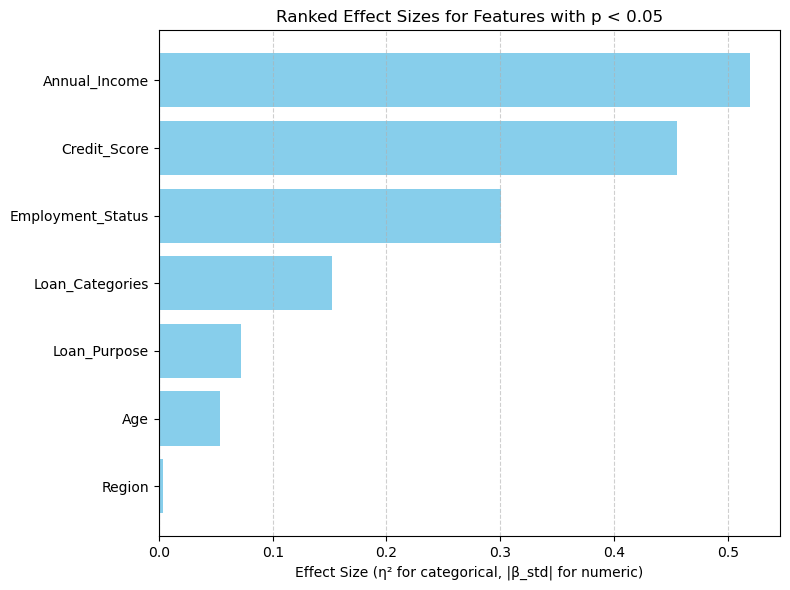

In [56]:
plt.figure(figsize=(8, 6))
plt.barh(eff_df['Feature'], eff_df['Effect_Size'], color='skyblue')
plt.xlabel("Effect Size (η² for categorical, |β_std| for numeric)")
plt.title("Ranked Effect Sizes for Features with p < 0.05")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [64]:
def compute_metrics(GT, R):
    # True Positives, False Positives, False Negatives
    TP = GT & R
    FP = R - GT
    FN = GT - R
    
    # Counts
    tp, fp, fn = len(TP), len(FP), len(FN)
    
    # Metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / len(GT) if len(GT) > 0 else 0
    fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {
        'TP': TP, 'FP': FP, 'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'FDR': fdr
    }


GT = {"annual_income", "credit_score","Employment_Status","Loan_Categories","Loan_Purpose"}
R  = {"annual_income",
        "credit_score",
        "Employment_Status",
        "Loan_Categories",
        "Loan_Purpose",
     "Age",
     "Region"}

In [66]:
metrics = compute_metrics(GT, R)

In [68]:
print("True Positives (TP):", metrics['TP'])
print("False Positives (FP):", metrics['FP'])
print("False Negatives (FN):", metrics['FN'])
print(f"Precision: {metrics['Precision']:.3f}")
print(f"Recall:    {metrics['Recall']:.3f}")
print(f"FDR:       {metrics['FDR']:.3f}")

True Positives (TP): {'credit_score', 'Loan_Purpose', 'Employment_Status', 'Loan_Categories', 'annual_income'}
False Positives (FP): {'Region', 'Age'}
False Negatives (FN): set()
Precision: 0.714
Recall:    1.000
FDR:       0.286


In [71]:
from semopy import Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [73]:
categorical_cols = ['Loan_Purpose', 'Employment_Status', 'Loan_Categories', 'Region', 'Marital_Status']
df_encoded = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=False)
df_encoded.columns = df_encoded.columns.str.replace("-", "_").str.replace(" ", "_")

In [75]:
nums = ['Annual_Income','Credit_Score','Employment_Length','Age','Loan_Term']
scaler = StandardScaler()
df_encoded[nums] = scaler.fit_transform(df_encoded[nums])

In [77]:
model_desc = """
# Measurement model (latent constructs from categorical dummy variables)
LoanPurpose      =~ Loan_Purpose_Car + Loan_Purpose_Home + Loan_Purpose_Personal
EmploymentStatus =~ Employment_Status_Self_employed + Employment_Status_Unemployed + Employment_Status_Employed
LoanCategories   =~ Loan_Categories_Large + Loan_Categories_Medium + Loan_Categories_Small
RegionLatent     =~ Region_South + Region_East + Region_West + Region_North
MaritalStatus    =~ Marital_Status_Divorced + Marital_Status_Married + Marital_Status_Single

# Structural model: all features pointing to Approval_Probability
pred_value ~ Annual_Income + Credit_Score + Employment_Length + Age + Loan_Term + LoanPurpose + EmploymentStatus + LoanCategories + RegionLatent + MaritalStatus
"""


In [79]:
model = Model(model_desc)
model.fit(df_encoded)

SolverResult(fun=18.733576659082782, success=True, n_it=55, x=array([-4.92265387e-01, -4.97843403e-01, -4.84116604e-01, -5.05824114e-01,
       -4.89693335e-01, -5.00196663e-01, -3.23281691e-01, -3.21123074e-01,
       -3.45483126e-01, -4.77965457e-01, -5.12085588e-01,  1.02036613e-01,
        9.06739985e-02,  6.30434622e-03, -7.51471729e-03, -4.72531133e-03,
       -6.54087605e-02,  1.90299611e-01, -1.37141848e-01,  6.27914472e-03,
       -3.25924910e-03,  2.21362155e-01, -5.51136122e-03, -7.96734177e-03,
        1.68387627e-01,  1.30680641e-12,  1.68237748e-01,  2.23450332e-01,
        4.21064293e-03, -5.33632414e-03, -3.89974207e-03,  2.23638140e-01,
       -5.28835969e-03,  4.18787928e-03, -4.90115921e-03, -1.09145523e-03,
        1.29647362e-12,  1.66794705e-01,  1.66861042e-01,  1.30971045e-12,
        1.66691891e-01,  1.66696157e-01,  2.24187426e-01, -3.50711862e-03,
        1.33894194e-12,  1.65995414e-01,  1.66178886e-01,  1.90006048e-01,
        1.64242034e-01,  1.69717551e-0

In [81]:
std_est = model.inspect(std_est=True)

In [83]:
lhs_col = "lhs" if "lhs" in std_est.columns else "lval"
rhs_col = "rhs" if "rhs" in std_est.columns else "rval"
p_col = "pval" if "pval" in std_est.columns else "p-value"

effect_col = "std_est" if "std_est" in std_est.columns else "Est. Std" 

# Filter: Only regression paths into the output variable
mask = (std_est["op"] == "~") & (std_est[lhs_col] == "pred_value")
results = std_est.loc[mask, [rhs_col, effect_col, p_col]].rename(
    columns={rhs_col: "Feature", effect_col: "EffectSize", p_col: "p_value"}
)

# Rank by absolute effect size
results["abs_effect"] = results["EffectSize"].abs()
results = results.sort_values("abs_effect", ascending=False)

In [87]:
# results = pd.DataFrame(data)
results["abs_effect"] = results["EffectSize"].abs()

# Filter features with p-value < 0.05
significant = results[results["p_value"] < 0.05]

# Sort by effect size for a clean visual
significant = significant.sort_values("abs_effect",ascending = True)

In [89]:
significant

,Feature,EffectSize,p_value,abs_effect
20,Loan_Term,-0.023770,0.00279,0.023770
18,Employment_Length,0.031713,0.000066,0.031713
19,Age,-0.037802,0.000002,0.037802
21,LoanPurpose,-0.155599,0.0,0.155599
23,LoanCategories,-0.326106,0.0,0.326106
22,EmploymentStatus,0.450389,0.0,0.450389
17,Credit_Score,0.456122,0.0,0.456122
16,Annual_Income,0.513280,0.0,0.513280


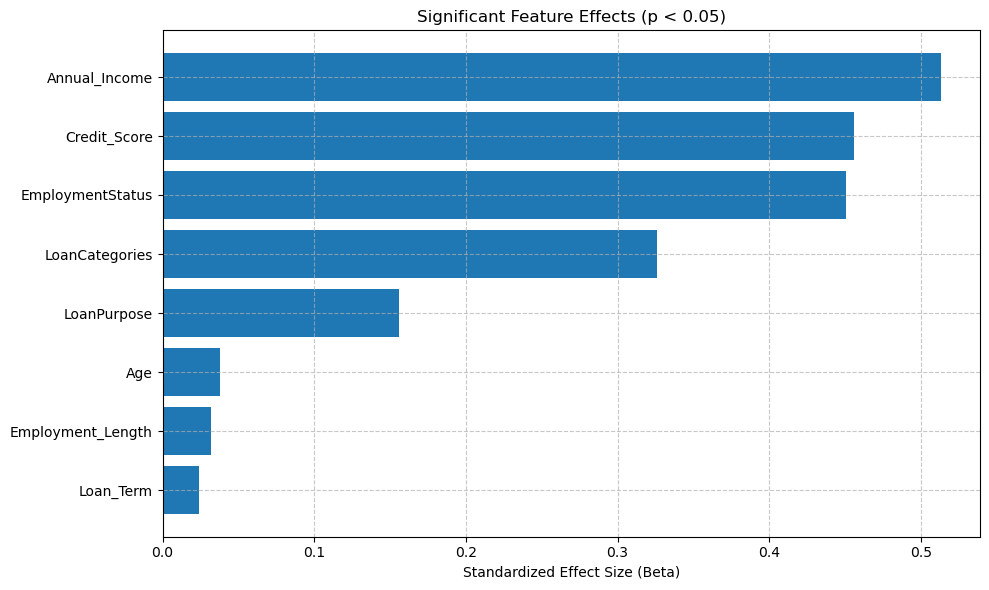

In [91]:
plt.figure(figsize=(10, 6))
plt.barh(significant["Feature"], significant["abs_effect"])
plt.xlabel("Standardized Effect Size (Beta)")
plt.title("Significant Feature Effects (p < 0.05)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [99]:
def compute_metrics(GT, R):
    # True Positives, False Positives, False Negatives
    TP = GT & R
    FP = R - GT
    FN = GT - R
    
    # Counts
    tp, fp, fn = len(TP), len(FP), len(FN)
    
    # Metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / len(GT) if len(GT) > 0 else 0
    fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {
        'TP': TP, 'FP': FP, 'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'FDR': fdr
    }


GT = {"annual_income", "credit_score","Employment_Status","Loan_Categories","Loan_Purpose"}
R  = {"annual_income",
        "credit_score",
      "Employment_Status",
        "Loan_Categories",
      "Age",
        "Employment_Length",
        "Loan_Term"}

In [101]:
metrics = compute_metrics(GT, R)

In [103]:
print("True Positives (TP):", metrics['TP'])
print("False Positives (FP):", metrics['FP'])
print("False Negatives (FN):", metrics['FN'])
print(f"Precision: {metrics['Precision']:.3f}")
print(f"Recall:    {metrics['Recall']:.3f}")
print(f"FDR:       {metrics['FDR']:.3f}")

True Positives (TP): {'credit_score', 'Loan_Categories', 'annual_income', 'Employment_Status'}
False Positives (FP): {'Age', 'Employment_Length', 'Loan_Term'}
False Negatives (FN): {'Loan_Purpose'}
Precision: 0.571
Recall:    0.800
FDR:       0.429


In [76]:
import shap
import numpy as np
import psutil
import os
import torch.optim as optim
import matplotlib.pyplot as plt

In [77]:
X_train_all = np.hstack([train_num, train_cat.values])  # (14000, D)
X_test_all  = np.hstack([test_num,  test_cat.values])   # (6000, D)



In [80]:
feature_names = num_feats + train_cat.columns.tolist()  # length D


In [75]:
feature_names

['Annual_Income',
 'Credit_Score',
 'Employment_Length',
 'Age',
 'Loan_Term',
 'Loan_Purpose_Car',
 'Loan_Purpose_Home',
 'Loan_Purpose_Personal',
 'Employment_Status_Employed',
 'Employment_Status_Self-employed',
 'Employment_Status_Unemployed',
 'Loan_Categories_Large',
 'Loan_Categories_Medium',
 'Loan_Categories_Small',
 'Region_East',
 'Region_North',
 'Region_South',
 'Region_West',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single']

In [82]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

OneHotRNNReg(
  (rnn): RNN(1, 32, batch_first=True)
  (head): Linear(in_features=32, out_features=1, bias=True)
)

In [84]:

def predict_regression(x_np):
    """
    x_np: np.array shape (batch, D)
    returns np.array shape (batch,) of model outputs
    """
    with torch.no_grad():
        # convert to tensor and add sequence dim: [batch, seq_len=D, 1]
        t = torch.from_numpy(x_np).float().unsqueeze(-1).to(device)
        out = model(t).cpu().numpy().flatten()   # raw regression output
    return out

In [86]:
bg_size    = 200
bg_indices = np.random.choice(len(X_train_all), size=bg_size, replace=False)
background = X_train_all[bg_indices]  # (200, D)


In [88]:
explainer = shap.KernelExplainer(predict_regression, background)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [90]:
batch_size     = 512
all_shap       = []

for start in range(0, X_test_all.shape[0], batch_size):
    end = min(start + batch_size, X_test_all.shape[0])
    Xb = X_test_all[start:end]  # (batch, D)

    # monitor memory
    mem = psutil.virtual_memory()
    print(f"Batch {start}-{end}: free RAM = {mem.available/1e9:.2f} GB")

    # nsamples trades speed vs. accuracy
    sv = explainer.shap_values(Xb, nsamples=100)  # (batch, D)
    all_shap.append(sv)


Batch 0-512: free RAM = 4.59 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 512-1024: free RAM = 4.53 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1024-1536: free RAM = 4.54 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 1536-2048: free RAM = 4.61 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2048-2560: free RAM = 4.47 GB


  0%|          | 0/512 [00:00<?, ?it/s]

Batch 2560-3000: free RAM = 4.40 GB


  0%|          | 0/440 [00:00<?, ?it/s]

In [92]:
all_shap_values = np.vstack(all_shap)

In [94]:
mean_abs = pd.Series(
    np.abs(all_shap_values).mean(axis=0),
    index=feature_names
).sort_values()

# Print the values
print("Mean |SHAP value| per feature:")
print(mean_abs)


Mean |SHAP value| per feature:
Employment_Length                  0.001257
Loan_Term                          0.002466
Age                                0.003036
Region_East                        0.003866
Loan_Purpose_Home                  0.005887
Region_West                        0.006305
Region_South                       0.007001
Region_North                       0.007141
Loan_Categories_Medium             0.009942
Loan_Purpose_Car                   0.014502
Marital_Status_Married             0.014555
Loan_Purpose_Personal              0.015589
Marital_Status_Single              0.018174
Marital_Status_Divorced            0.018409
Employment_Status_Employed         0.019971
Loan_Categories_Small              0.029530
Loan_Categories_Large              0.048677
Employment_Status_Unemployed       0.049914
Employment_Status_Self-employed    0.063521
Credit_Score                       0.068922
Annual_Income                      0.098816
dtype: float64


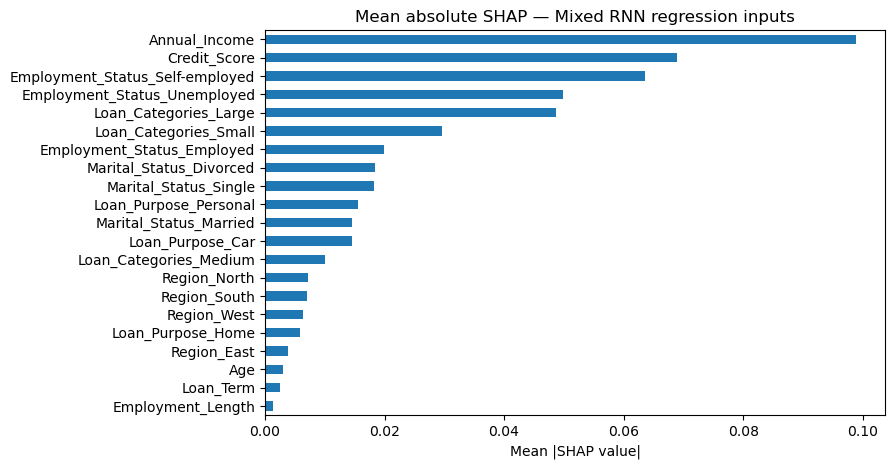

In [96]:
os.makedirs("shap", exist_ok=True)
plt.figure(figsize=(8,5))
mean_abs.plot.barh()
plt.xlabel("Mean |SHAP value|")
plt.title("Mean absolute SHAP — Mixed RNN regression inputs")
# plt.tight_layout()
# plt.savefig("shap/MixedRNN_regression_shap_summary.jpg", dpi=300)
plt.show()

In [98]:
shap_feats = [
    'Loan_Purpose_Car', 'Loan_Purpose_Home', 'Loan_Purpose_Personal',
    'Employment_Status_Employed','Employment_Status_Self-employed',
    'Employment_Status_Unemployed',
    'Loan_Categories_Large','Loan_Categories_Medium','Loan_Categories_Small',
    'Region_East','Region_North','Region_South','Region_West',
    'Marital_Status_Divorced','Marital_Status_Married','Marital_Status_Single',
    'Annual_Income','Credit_Score','Employment_Length','Age','Loan_Term'
]

# 2) The 10 original variables you want:
orig_feats = [
    'Annual_Income', 'Credit_Score', 'Employment_Length', 'Age', 'Loan_Term',
    'Loan_Purpose', 'Employment_Status', 'Loan_Categories', 'Region', 'Marital_Status'
]

# 3) Suppose `all_shap_values` is your array of shape (n_samples, 21).
#    First compute the mean absolute SHAP per encoded feature:
mean_abs_enc = pd.Series(
    np.abs(all_shap_values).mean(axis=0),
    index=shap_feats
)

# 4) Build a map from each encoded feature → its original parent:
mapping = {}
for f in shap_feats:
    if f in ['Annual_Income','Credit_Score','Employment_Length','Age','Loan_Term']:
        mapping[f] = f
    else:
        # anything before the last underscore is the parent:
        parent = f.rsplit('_',1)[0]
        mapping[f] = parent

# 5) Aggregate by summing all SHAP values for each parent:
mean_abs_orig = mean_abs_enc.groupby(mapping).sum()

# 6) Reindex to your desired order:
mean_abs_orig = mean_abs_orig.reindex(orig_feats)
mean_orig_sorted = mean_abs_orig.sort_values(ascending=False)


In [100]:
mean_orig_sorted

Region               0.172054
Loan_Purpose         0.168995
Loan_Categories      0.041446
Marital_Status       0.040537
Employment_Status    0.020003
Employment_Length    0.018409
Loan_Term            0.018174
Age                  0.014555
Annual_Income        0.007001
Credit_Score         0.006305
dtype: float64

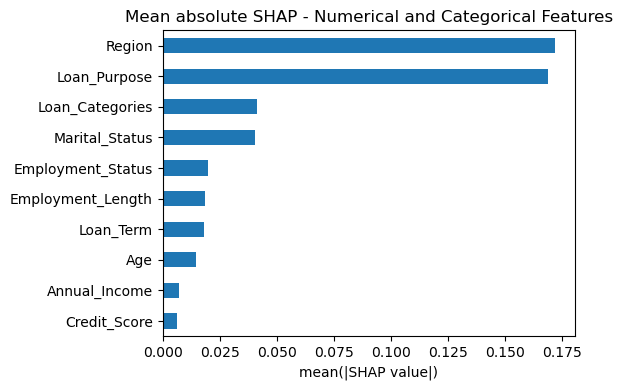

In [102]:
os.makedirs("shap", exist_ok=True)
plt.figure(figsize=(6,4))
mean_orig_sorted.plot.barh()
plt.xlabel("mean(|SHAP value|)")
plt.title("Mean absolute SHAP - Numerical and Categorical Features")
plt.gca().invert_yaxis()
plt.tight_layout()
out_path = os.path.join("shap", "RNN_numerical categorical_regression_test_shap_summary.jpg")
plt.savefig(out_path, format="jpg", dpi=300)
plt.show()

In [69]:
def compute_metrics(GT, R):
    # True Positives, False Positives, False Negatives
    TP = GT & R
    FP = R - GT
    FN = GT - R
    
    # Counts
    tp, fp, fn = len(TP), len(FP), len(FN)
    
    # Metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / len(GT) if len(GT) > 0 else 0
    fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {
        'TP': TP, 'FP': FP, 'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'FDR': fdr
    }


GT = {"annual_income", "credit_score","Employment_Status","Loan_Categories","Loan_Purpose"}
R  = {"Loan_Purpose",
        "Region",
        "credit_score",
        "Loan_Categories",
        "Marital_Status",
        "Age",
        "Employment_Length",
     "Loan_Term",
    "Employment_Status",
    "Credit_Score",
     "Annual_Income"}

In [71]:
metrics = compute_metrics(GT, R)

In [73]:
print("True Positives (TP):", metrics['TP'])
print("False Positives (FP):", metrics['FP'])
print("False Negatives (FN):", metrics['FN'])
print(f"Precision: {metrics['Precision']:.3f}")
print(f"Recall:    {metrics['Recall']:.3f}")
print(f"FDR:       {metrics['FDR']:.3f}")

True Positives (TP): {'Loan_Purpose', 'credit_score', 'Loan_Categories', 'Employment_Status'}
False Positives (FP): {'Age', 'Marital_Status', 'Annual_Income', 'Credit_Score', 'Region', 'Loan_Term', 'Employment_Length'}
False Negatives (FN): {'annual_income'}
Precision: 0.364
Recall:    0.800
FDR:       0.636
